In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import veritas

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Create a 2D synthetic dataset and take a look at it

In [2]:
x, y = make_classification(n_samples=1000, n_features=2, n_redundant=0,
                           n_informative=2, n_clusters_per_class=2,
                           random_state=6)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25,
                                                random_state=6)

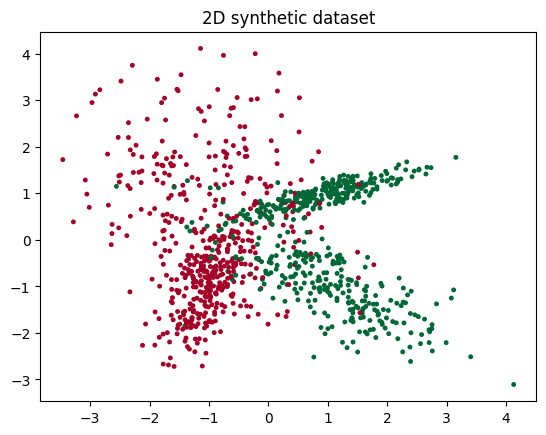

In [3]:
plt.figure()
plt.title("2D synthetic dataset")
plt.scatter(x[:, 0], x[:, 1], marker=".", c=y, s=25, vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.show()

## Train a sklearn RandomForest model

In [4]:
model = RandomForestClassifier(n_estimators=10).fit(xtrain, ytrain)
at = veritas.get_addtree(model)

SKLEARN: RF classifier with 1 classes


In [5]:
pred0 = model.predict_proba(xtest)[:, 1]
pred1 = at.predict(xtest).ravel()
pred0, pred1

(array([0. , 0.1, 1. , 0. , 0.1, 0. , 1. , 0. , 0.9, 1. , 1. , 1. , 1. ,
        1. , 0. , 1. , 0. , 0.9, 0.3, 1. , 1. , 0. , 0.2, 0. , 0. , 1. ,
        0. , 1. , 0. , 0.8, 0.7, 0.7, 0. , 1. , 0.2, 1. , 0.7, 0. , 0.5,
        0.2, 1. , 0. , 1. , 1. , 1. , 0. , 0. , 0.9, 1. , 0. , 0. , 0.7,
        1. , 1. , 1. , 0.8, 0.1, 0.8, 1. , 0.1, 0. , 0.4, 0. , 0.1, 1. ,
        0.1, 1. , 0. , 0.6, 0.3, 1. , 1. , 0. , 0. , 0.9, 0.1, 0.1, 1. ,
        1. , 0.1, 1. , 0. , 0.3, 0. , 1. , 1. , 0.2, 1. , 1. , 0.5, 1. ,
        1. , 1. , 0. , 1. , 0. , 1. , 0.1, 0.8, 0.6, 1. , 0. , 0.9, 0.6,
        1. , 0.9, 0. , 0.1, 0. , 0. , 0. , 0.1, 1. , 0.9, 0. , 1. , 0.8,
        0. , 0.1, 1. , 1. , 0.1, 0.1, 0.9, 0.4, 1. , 0. , 0. , 0.3, 0. ,
        0. , 1. , 0.4, 1. , 0. , 1. , 1. , 0.2, 1. , 0.2, 0. , 0.9, 1. ,
        0.3, 0. , 0.6, 0.1, 0. , 1. , 0.1, 1. , 0.9, 0. , 0.9, 0.3, 0. ,
        0.1, 0.3, 0. , 1. , 0.1, 1. , 0.9, 0.1, 0.2, 1. , 1. , 1. , 1. ,
        0. , 1. , 0.6, 0.1, 0.2, 0.1, 0. , 0.8, 1. 

In [6]:
model = xgb.XGBClassifier(n_estimators=10).fit(xtrain,ytrain)
at = veritas.get_addtree(model) 


| XGBOOST's base_score
|   base_score diff std      1.4461501726124228e-07 OK
|   base_score reported      0.51599455
|   versus manually detected 0.06400003494063276
|   abs err                  0.4519945150593673
|   rel err                  0.8759676145016788
|   (!) base_score NOT THE SAME with relative tolerance 0.0001



## Measure the predictive performance of the model

In [7]:
acc_train = accuracy_score(ytrain, model.predict(xtrain))
acc_test = accuracy_score(ytest, model.predict(xtest))
is_conversion_correct = veritas.test_conversion(at, xtest, model.predict_proba(xtest)[:,1])
print(f"Train acc: {acc_train*100:.1f}%, test acc: {acc_test*100:.1f}% wrt true labels",
      f"(check {'OK' if is_conversion_correct else 'NOT OK'})")

test_conversion: no problems detected (rel_tol 0.0001)
Train acc: 94.8%, test acc: 91.2% wrt true labels (check OK)


## Use Veritas to evaluate adversarial accuracy and collect generated adversarial examples

Adversarial accuracy is the fraction of test examples that:

1. are correctly classified by the model
2. cannot be turned into a valid adversarial example (given perturbation margin eps)

In [8]:
eps = 0.1 # maximum perturbation size
ytest_pred = at.eval(xtest)[:, 0] > 0.0

In [9]:
adv_found, robust = [], []
advs = [] 

time_full_search = time.time()

for i in range(xtest.shape[0]):
    base_example = xtest[i, :]
    
    # only search on correctly classified examples
    # it is unclear what an adversarial example of a misclassified example is
    if ytest_pred[i] != ytest[i]:
        continue
    
    # minimize model output when we have a positive example
    heur = veritas.HeuristicType.MAX_OUTPUT
    if ytest[i]:
        heur = veritas.HeuristicType.MIN_OUTPUT
    config = veritas.Config(heur)
    
    # make veritas stop the search when it is certain that the prediction cannot flip
    config.ignore_state_when_worse_than = 0.0
    
    # allow each attribute to vary of at most eps either side
    prune_box = [veritas.Interval(x-eps, x+eps) for x in base_example]

    # Veritas will look for the example in the prune_box with MIN/MAX output
    search = config.get_search(at, prune_box)
    
    # can set max time or num. steps per search
    # stop_reason allows inspecting why search ended
    # e.g., veritas.StopReason.OPTIMAL: optimal solution reached
    max_num_seconds = 0.5
    num_steps = 500
    stop_reason = search.step_for(max_num_seconds, num_steps) 

    if search.num_solutions() > 0:
        # an adversarial example has been found
        adv_found.append(i)
        sol = search.get_solution(0)  # if multiple ones were found, the best in in position 0

        if sol.output < 0.0:  #  skip, not able to flip the label
            continue

        adv_example = veritas.get_closest_example(sol, base_example, eps=1e-4)
        pred = at.predict(np.array([base_example, adv_example]))[:, 0]
        advs.append({
            "index": i,
            "adv_example": adv_example,
            "base_example": base_example,
            "pred": pred,
        })

    else:
        robust.append(i)
        
time_full_search = time.time() - time_full_search

## Evaluate adversarial accuracy

In [10]:
num_test_examples = xtest.shape[0]
misclassified = np.sum(ytest != ytest_pred)
print()
print(f"Wrongly classified examples: {misclassified}/{num_test_examples}")
print(f"Non-robust examples: {len(adv_found)}/{num_test_examples}")
print(f"Robust examples: {len(robust)}/{num_test_examples}")

print()
print(f">> Adversarial accuracy: {100.0 - 100.0*((misclassified+len(adv_found))/num_test_examples):.1f}%")
print(f">> Time for full search: {time_full_search:.3f} seconds")


Wrongly classified examples: 22/250
Non-robust examples: 24/250
Robust examples: 204/250

>> Adversarial accuracy: 81.6%
>> Time for full search: 0.008 seconds


## Look at an example of an adversarial example

Plot the adversarial example over the decision surface of the classifier

In [11]:
i = 10

index, base_ex, adv_ex, pred = advs[i]["index"], advs[i]["base_example"], advs[i]["adv_example"], advs[i]["pred"]
print(f"Adversarial example for index {index}:")
print(f" - base example:        {base_ex}, {pred[0]*100:.1f}%")
print(f" - adversarial example: {adv_ex}, {pred[1]*100:.1f}%")

#plt.figure()
#plt.title("2D synthetic dataset")
#plt.scatter(x[:, 0], x[:, 1], marker=".", c=y, s=25, alpha=0.2, vmin=0.0, vmax=1.0, cmap="RdYlGn")
#plt.scatter([base_ex[0]], [base_ex[1]], marker="x", c=y[index], vmin=0.0, vmax=1.0, cmap="RdYlGn", label="base example")
#plt.scatter([adv_ex[0]], [adv_ex[1]], marker="x", c=1-y[index], vmin=0.0, vmax=1.0, cmap="RdYlGn", label="adversarial example")
#plt.legend()
#plt.show()

Adversarial example for index 191:
 - base example:        [-0.55194711 -0.54433534], 19.5%
 - adversarial example: [-0.59117    -0.63950376], 67.2%


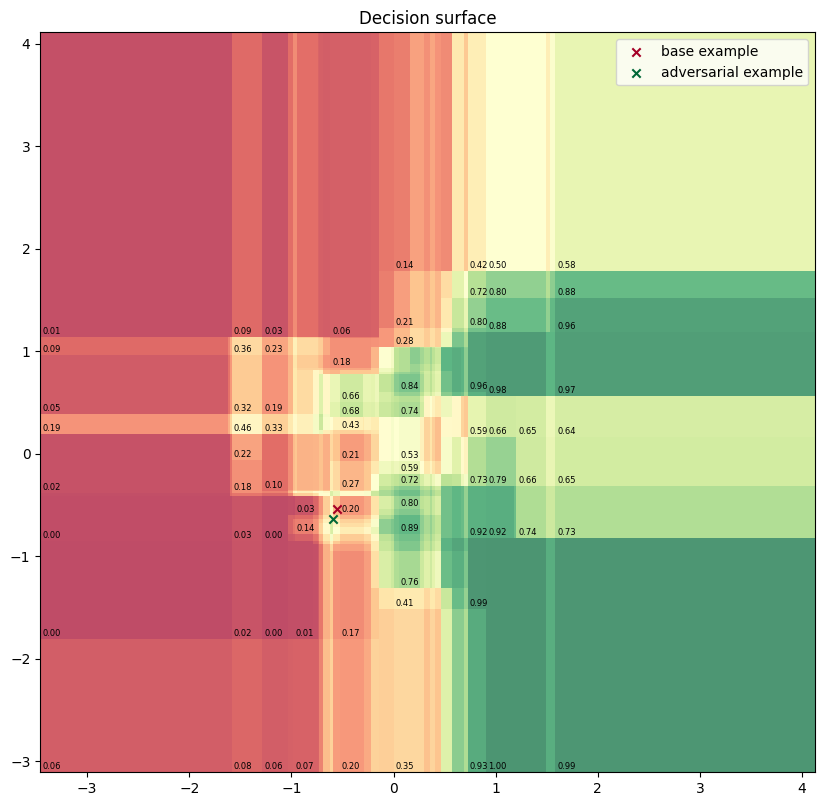

In [12]:
config = veritas.Config(veritas.HeuristicType.MAX_OUTPUT)
config.stop_when_optimal = False
search = config.get_search(at)

stop_reason = veritas.StopReason.NONE
while stop_reason != veritas.StopReason.NO_MORE_OPEN:
    stop_reason = search.steps(1000)

minx, maxx = min(x[:, 0]), max(x[:, 0])
miny, maxy = min(x[:, 1]), max(x[:, 1])
cmap = plt.colormaps["RdYlGn"]

fig, ax = plt.subplots(figsize=(10, 10))

num_sols = search.num_solutions()
min_output = search.get_solution(num_sols-1).output
max_output = search.get_solution(0).output
for i in range(min(10_000, num_sols)):
    sol = search.get_solution(i)
    scaled_output = (sol.output-min_output)/(max_output-min_output)
    box = sol.box()
    ival0 = box.get(0, veritas.Interval())
    ival1 = box.get(1, veritas.Interval())
    x0 = max(minx, ival0.lo)
    y0 = max(miny, ival1.lo)
    x1 = min(maxx, ival0.hi)
    y1 = min(maxy, ival1.hi)
    w, h = x1-x0, y1-y0
    rect = plt.Rectangle((x0, y0), w, h,
                         fc=cmap(scaled_output),
                         lw=0.0, ec="black", alpha=0.7)

    ax.add_patch(rect)
    if w > 0.15 and h > 0.10:
        ax.text(x0+0.02, y0+0.01, f"{scaled_output:.2f}",
               fontsize=6, ha="left", va="bottom")

#plt.scatter(x[:, 0], x[:, 1], marker=".", c=y, s=25, alpha=0.7, vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.scatter([base_ex[0]], [base_ex[1]], marker="x", c=y[index], vmin=0.0, vmax=1.0, cmap="RdYlGn", label="base example")
plt.scatter([adv_ex[0]], [adv_ex[1]], marker="x", c=1-y[index], vmin=0.0, vmax=1.0, cmap="RdYlGn", label="adversarial example")

#ax.scatter(xtrain[ytrain==1, 0], xtrain[ytrain==1, 1], marker='.', c="black", s=10, linewidths=0.8, label="pos")
#ax.scatter(xtrain[ytrain==0, 0], xtrain[ytrain==0, 1], marker='x', c="black", s=10, linewidths=0.8, label="neg")
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])
ax.legend()

ax.set_title("Decision surface")
fig.subplots_adjust(top=0.85)
plt.show()